# This is a sandbox for setting up a run of the simulation on `COMMERCIAL` only. 

* It can be run on a small subsample pandas DataFrame


In [1]:
import pandas as pd
import numpy as np
import replicaEVSE.load_curve as sim
import os
import joblib
import dask.dataframe as dd
import plotly.express as px
import datetime as dt

%reload_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

datadir = '../../../data'
mode = 'COMMERCIAL'
simulation_id = 'dev'
test = True

#Created in the EIA_data_download.ipynb notebook
existing_load=pd.read_csv('../../../data/EIA_demand_summary.csv')
sample_frac=.2
if test:
    # df = pd.read_parquet(os.path.join(datadir, 'wa_pop_and_trips_subsample.parquet'))
    df = pd.read_parquet(os.path.join(datadir, 'wa_pop_and_trips_sorted.parquet'))
    # df = df.loc[df['mode'] == mode]
    df = df.sample(frac=sample_frac, random_state=1)
    # df = df.sort_values(by=['person_id', 'start_time']).reset_index(drop=True)
    simulation_id = 'dev'
    print(len(df))

else: 
    # read in the joined trips and population data sets
    merged_df = pd.read_parquet(os.path.join(datadir, 'wa_pop_and_trips_sorted.parquet'))

    # right now, only look at private auto trips
    df = merged_df.loc[merged_df['mode'] == mode]

10345454


In [2]:
df['mode'].value_counts()

mode
PRIVATE_AUTO         5425500
CARPOOL              3282415
WALKING               986854
COMMERCIAL            291062
OTHER_TRAVEL_MODE     126752
ON_DEMAND_AUTO         92828
PUBLIC_TRANSIT         81482
BIKING                 58561
Name: count, dtype: int64

In [42]:
df_day=df.loc[df['weekday'] == 'saturday']

df_medium = df_day.loc[df_day['vehicle_type'] == 'MEDIUM_COMMERCIAL']
df_heavy = df_day.loc[df_day['vehicle_type'] == 'HEAVY_COMMERCIAL']

df_medium = df_medium.sort_values(by=['person_id', 'start_time']).reset_index(drop=True)
df_heavy = df_heavy.sort_values(by=['person_id', 'start_time']).reset_index(drop=True)

print(len(df_medium))
print(len(df_heavy))
#df = df.compute()

92178
9196


In [43]:
df_medium.head()

,activity_id,person_id,mode,travel_purpose,previous_activity_type,start_time,end_time,distance_miles,vehicle_type,origin_bgrp,origin_bgrp_lat,origin_bgrp_lng,destination_bgrp,destination_bgrp_lat,destination_bgrp_lng,origin_land_use_l1,origin_land_use_l2,origin_building_use_l1,origin_building_use_l2,destination_land_use_l1,destination_land_use_l2,destination_building_use_l1,destination_building_use_l2,origin_lat,origin_lng,destination_lat,destination_lng,weekday,household_id,BLOCKGROUP,BLOCKGROUP_work,BLOCKGROUP_school,TRACT,TRACT_work,TRACT_school,age_group,age,sex,race,ethnicity,individual_income_group,individual_income,employment,education,school_grade_attending,industry,household_role,subfamily_number,subfamily_relationship,commute_mode,tenure,migration,household_size,household_income_group,household_income,family_structure,vehicles,building_type,resident_type,language,lat,lng,lat_work,lng_work,lat_school,lng_school,wfh,charge_type
0,6919464799064147587,10000091769615679194,COMMERCIAL,COMMERCIAL,COMMERCIAL,0 days 08:56:25,0 days 08:59:32,1.687790,MEDIUM_COMMERCIAL,530330317035,47.379404,-122.157552,530330295041,47.383328,-122.194544,nan,nan,nan,nan,nan,nan,nan,nan,47.38672,-122.16316,47.38672,-122.19886,saturday,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,PUBLIC
1,12750648410754962578,10000547888263965654,COMMERCIAL,COMMERCIAL,COMMERCIAL,0 days 11:54:45,0 days 12:08:19,5.277299,MEDIUM_COMMERCIAL,530330047002,47.662149,-122.372103,530330004011,47.728654,-122.348819,nan,nan,nan,nan,nan,nan,nan,nan,47.66584,-122.37876,47.73331,-122.35542,saturday,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,PUBLIC
2,7651301162284314545,10000933712651057465,COMMERCIAL,COMMERCIAL,COMMERCIAL,0 days 11:26:44,0 days 11:31:13,2.037189,MEDIUM_COMMERCIAL,530330204013,47.768139,-122.312948,530330204024,47.767239,-122.287898,nan,nan,nan,nan,nan,nan,nan,nan,47.76471,-122.30735,47.76194,-122.28813,saturday,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,PUBLIC
3,7097602949888501802,10000986517564575960,COMMERCIAL,COMMERCIAL,COMMERCIAL,0 days 09:33:28,0 days 10:50:48,67.307276,MEDIUM_COMMERCIAL,530459611003,47.223127,-122.938431,530530731222,47.106296,-122.258495,nan,nan,nan,nan,nan,nan,nan,nan,47.21350,-123.01185,47.10705,-122.25791,saturday,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,PUBLIC
4,11718081423801566659,10001027870755730617,COMMERCIAL,COMMERCIAL,COMMERCIAL,0 days 17:12:53,0 days 17:17:22,1.833170,MEDIUM_COMMERCIAL,530530625002,47.215957,-122.447135,530530623003,47.212010,-122.417039,nan,nan,nan,nan,nan,nan,nan,nan,47.21537,-122.45155,47.21163,-122.41859,saturday,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,PUBLIC


#### Filter by county
##### General FIPS format: State+County+Tract+Block

In [44]:
#53 is WA
#063 is Spokane

df_medium_spokane = df_medium[df_medium["destination_bgrp"].str.contains('53063')]
df_heavy_spokane = df_heavy[df_heavy["destination_bgrp"].str.contains('53063')]

In [45]:
#get rows from loads_df with nonzero load
#loads_df_medium = loads_df_medium[loads_df_medium["load_kW"]>0]
#loads_df_heavy = loads_df_heavy[loads_df_heavy["load_kW"]>0]

#add hours
ref_time=dt.datetime(2023, 1, 1,0,0)
df_medium_spokane["hour"]=(df_medium_spokane.end_time+ref_time).dt.hour
df_heavy_spokane["hour"]=(df_heavy_spokane.end_time+ref_time).dt.hour

/tmp/ipykernel_9012/891505092.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9012/891505092.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



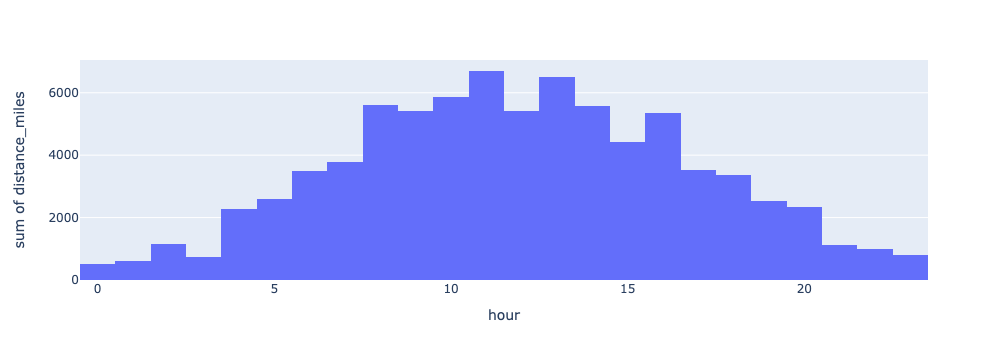

In [46]:
fig=px.histogram(df_medium_spokane, x="hour", y='distance_miles')
fig.show()

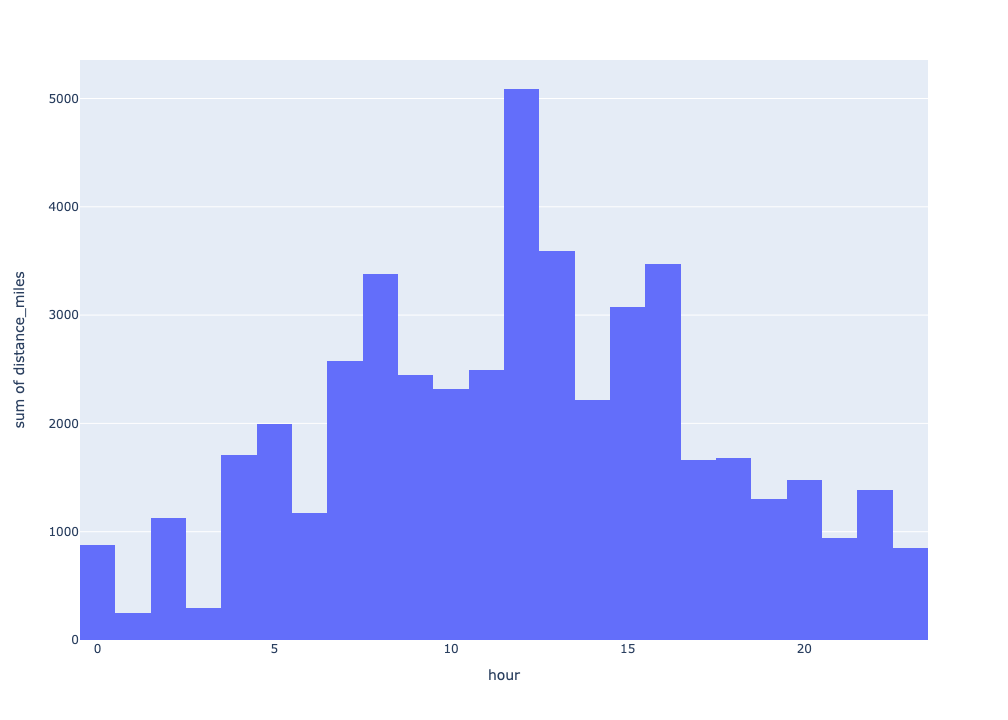

In [47]:
fig=px.histogram(df_heavy_spokane, x="hour", y='distance_miles')
fig.show()

In [48]:
#vehicle efficiency in kwh/mi
efficiency_medium=1.1
efficiency_heavy=2.2

#create load curve df
hourly_loads_medium=pd.DataFrame()
hourly_loads_heavy=pd.DataFrame()
hourly_loads_medium['hour']=range(24)
hourly_loads_heavy['hour']=range(24)
hourly_loads_medium['vmt']=[sum(df_medium_spokane[df_medium_spokane["hour"]==x]['distance_miles']) for x in range(24)]
hourly_loads_heavy['vmt']=[sum(df_heavy_spokane[df_heavy_spokane["hour"]==x]['distance_miles']) for x in range(24)]
mean_vmt_medium=sum(df_medium_spokane.distance_miles)/24
mean_vmt_heavy=sum(df_heavy_spokane.distance_miles)/24
hourly_loads_medium['charge']= (mean_vmt_medium+(mean_vmt_medium-hourly_loads_medium.vmt))*efficiency_medium/sample_frac 
hourly_loads_heavy['charge']= (mean_vmt_heavy+(mean_vmt_heavy-hourly_loads_heavy.vmt))*efficiency_heavy/sample_frac  

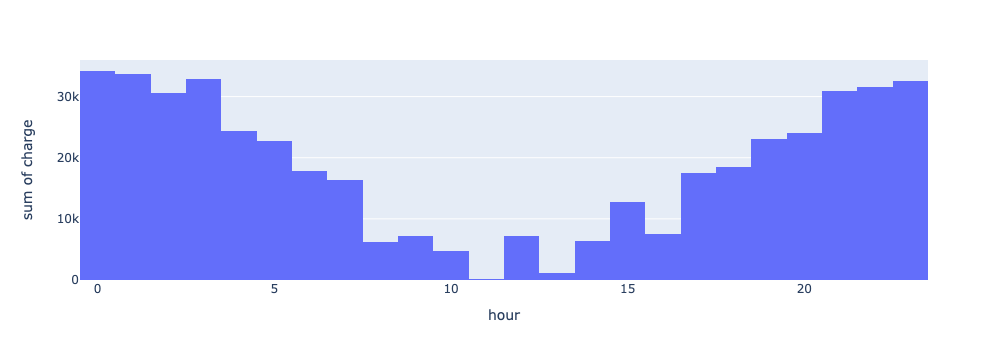

In [49]:
fig=px.histogram(hourly_loads_medium, x='hour', y='charge', nbins=24)
fig.show()

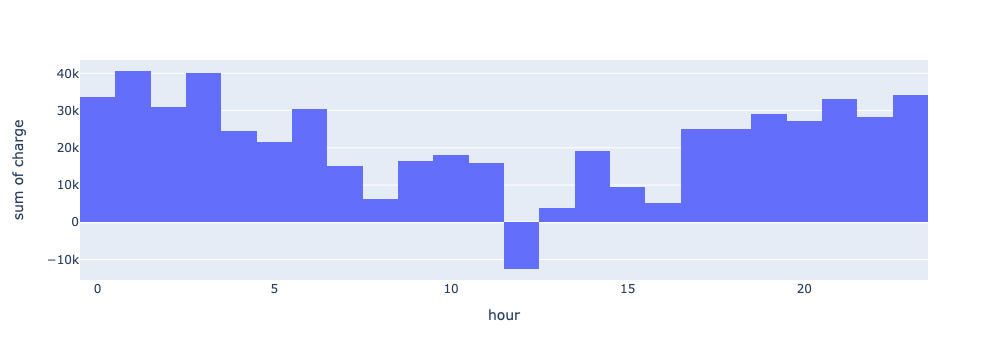

In [50]:
fig=px.histogram(hourly_loads_heavy, x='hour', y='charge', nbins=24)
fig.show()

In [51]:
#export load curves

# thursday=pd.DataFrame()
# thursday['hour']=hourly_loads_medium.hour.copy()
# thursday['mdv_load']=hourly_loads_medium.charge.copy()
# thursday['hdv_load']=hourly_loads_heavy.charge.copy()

# saturday=pd.DataFrame()
# saturday['hour']=hourly_loads_medium.hour.copy()
# saturday['mdv_load']=hourly_loads_medium.charge.copy()
# saturday['hdv_load']=hourly_loads_heavy.charge.copy()

In [7]:
# number_of_chunks = 10
# df_list_medium = np.array_split(df_medium_Spokane, number_of_chunks)
# df_list_heavy = np.array_split(df_heavy_Spokane, number_of_chunks)

In [16]:
#LOOK AT CHARGING RATES IN SIM
#Need to change energy consumption kwh/mi rates to match trucking numbers
#simulation needs to return orign and destination bgrp
# run the simulation in parallel
# df must be a pandas dataframe

# charge_sims_medium = joblib.Parallel(verbose=10, n_jobs=-1)(joblib.delayed(sim.simulate_person_load_commercial)(trips_df=df_i, 
#         existing_load=existing_load,
#         simulation_id=simulation_id,
#         managed=False) 
#      for df_i in df_list_medium)

# charge_sims_heavy = joblib.Parallel(verbose=10, n_jobs=-1)(joblib.delayed(sim.simulate_person_load_commercial)(trips_df=df_i, 
#         existing_load=existing_load,
#         simulation_id=simulation_id,
#         managed=False) 
#      for df_i in df_list_heavy)


### Restack the DataFrames

In [9]:
# restack the dataframes
# charges_list_medium = [x['charges'] for x in charge_sims_medium]
# loads_list_medium = [x['loads'] for x in charge_sims_medium]

# charges_list_heavy = [x['charges'] for x in charge_sims_heavy]
# loads_list_heavy = [x['loads'] for x in charge_sims_heavy]

Pandas significantly faster since we can fit these in memory. 

In [10]:
# restack the dataframes
# charges_df_medium = pd.concat(charges_list_medium)
# loads_df_medium = pd.concat(loads_list_medium) # huge ~200 million rows

# charges_df_heavy = pd.concat(charges_list_heavy)
# loads_df_heavy = pd.concat(loads_list_heavy) # huge ~200 million rows

In [ ]:
#charge quantity in an hour inversely proportional to vmt in that hour
    #can further tune this with emily's hwy/depot mile breakdown
    #for now let's say 90-10 on mdt
    #50-50 on hdt
    
#inverse vmt (max_vmt could 1.2x peak hourly cumulative vmt--eventually can be 99th percentile bootstrap approach)
#

In [ ]:
#calculate frac of county load for each bgrp

depot_bgrp_medium=loads_df_medium[loads_df_medium["hour"]>16]
depot_bgrp_heavy=loads_df_heavy[loads_df_heavy["hour"]>16]
bgrp_frac_medium = pd.DataFrame()
bgrp_frac_heavy = pd.DataFrame()
bgrp_frac_medium['name']= pd.unique(depot_bgrp_medium.destination_bgrp)
bgrp_frac_heavy['name']= pd.unique(depot_bgrp_heavy.destination_bgrp)
bgrp_frac_medium['frac']= [sum(depot_bgrp_medium["destination_bgrp"]==x)/len(depot_bgrp_medium) for x in bgrp_frac_medium.name]
bgrp_frac_heavy['frac']= [sum(depot_bgrp_heavy["destination_bgrp"]==x)/len(depot_bgrp_heavy) for x in bgrp_frac_heavy.name]

#total bgrp load = bgrp frac * county load * sampling frac * ev frac

#create list of destination bgrp past 9pm to serve as depot_zones
    #distribute load to proportionally to bgrp frequency

#what format should load curve be?-->prob parquet
    #bgrp, time, total load should be outputs
    #county level would also be handy
    
#depot_bgrp_medium[depot_bgrp_medium["destination_bgrp"]==bgrp_frac_medium[]

In [ ]:
######################    
#####FUTURE WORK######
######################

#look up average truck battery size, decide charger size
    #most have a max charge rate of ~250kw
    #add randomized fraction for teslas which can hit 1mw

#distribute 90-95% of load across depot zones 
#leave 5-10% to random daytime charging?

In [ ]:
#DEPRECATED

# Compute number of trips to reach max range

#medium duty
# range_mi = 200
# tot_distance = 0
# trip_counter = 0
# trip_list=[]

# for i in range(len(df_medium)):
#     trip = df_medium.iloc[i,]
#     tot_distance += trip['distance_miles']
#     trip_counter += 1
#     if tot_distance > range_mi:
#         trip_list.append(trip_counter)
#         tot_distance = 0
#         trip_counter = 0

# p_charge_medium=1/np.mean(trip_list)
# print(p_charge_medium)

# #heavy duty
# range_mi = 300
# tot_distance = 0
# trip_counter = 0
# trip_list=[]

# for i in range(len(df_heavy)):
#     trip = df_heavy.iloc[i,]
#     tot_distance += trip['distance_miles']
#     trip_counter += 1
#     if tot_distance > range_mi:
#         trip_list.append(trip_counter)
#         tot_distance = 0
#         trip_counter = 0

# p_charge_heavy=1/np.mean(trip_list)
# print(p_charge_heavy)
# trip_list